In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import os
import random

tfd = tfp.distributions
tfb = tfp.bijectors
tf.random.set_seed(1234)

ModuleNotFoundError: No module named 'data'

In [ ]:
# Hypter parameters
K = 30  # length of the flow
learning_rate = 1e-2
iterrations = 1e5

In [ ]:
sess = tf.InteractiveSession()

# True Density

In [ ]:
batch_size=512
DTYPE=tf.float32
NP_DTYPE=np.float32

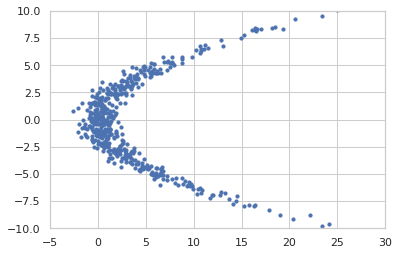

In [ ]:
DATASET = 1
if DATASET == 0:
    mean = [0.4, 1]
    A = np.array([[2, .3], [-1., 4]])
    cov = A.T.dot(A)
    print(mean)
    print(cov)
    X = np.random.multivariate_normal(mean, cov, 2000)
    plt.scatter(X[:, 0], X[:, 1], s=10, color='red')
    dataset = tf.data.Dataset.from_tensor_slices(X.astype(NP_DTYPE))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(buffer_size=X.shape[0])
    dataset = dataset.prefetch(3 * batch_size)
    dataset = dataset.batch(batch_size)
    data_iterator = dataset.make_one_shot_iterator()
    X_train = data_iterator.get_next()
elif DATASET == 1:
    x2_dist = tfd.Normal(loc=0., scale=4.)
    x2_samples = x2_dist.sample(batch_size)
    x1 = tfd.Normal(loc=.25 * tf.square(x2_samples),
                    scale=tf.ones(batch_size, dtype=DTYPE))
    x1_samples = x1.sample()
    x_samples = tf.stack([x1_samples, x2_samples], axis=1)
    X_train = sess.run(x_samples)
    plt.scatter(X_train[:, 0], X_train[:, 1], s=10)
    plt.xlim([-5, 30])
    plt.ylim([-10, 10])

In [ ]:
n_dims = X_train.shape[1]

# Define Planar Flow

## Planar
![planar](./images/planar.png)

In [ ]:

class PlanarFlow(tfb.Bijector, tf.Module):
    def __init__(self, input_dimensions, name="planar_flow"):
        super(PlanarFlow, self).__init__(
            forward_min_event_ndims=1,
            inverse_min_event_ndims=1,
            name=name)

        self.u = tf.Variable(np.random.uniform(-1., 1., size=(int(input_dimensions))), name='u', dtype=tf.float32, trainable=True)
        self.w = tf.Variable(np.random.uniform(-1., 1., size=(int(input_dimensions))), name='w', dtype=tf.float32, trainable=True)
        self.b = tf.Variable(np.random.uniform(-1., 1., size=(1)), name='b', dtype=tf.float32, trainable=True)
    
    def alpha(self):
        wu = tf.tensordot(self.w, self.u, 1)
        m = -1.0 + tf.nn.softplus(wu)
        return m - wu
        
    def _u(self):
        if tf.tensordot(self.w, self.u, 1) <= -1:
            alpha = self.alpha()
            z_para = tf.transpose(alpha * self.w / tf.math.sqrt(tf.reduce_sum(self.w ** 2.0)))
            self.u.assign_add(z_para)  # self.u = self.u + z_para
        
    def h(self, alpha, r=0):
        return tf.math.tanh(alpha)

    def h_prime(self, alpha, r=0):
        return 1.0 - tf.math.tanh(alpha) ** 2.0

    def _forward(self, z):
        # f(z) = z + u * h(dot(w.T, z) + b)
        inter_1 = self.h(tf.tensordot(z, self.w, 1) + self.b)
        return tf.add(z, tf.tensordot(inter_1, self.u, 0))

    def _inverse(self, z):
        return self._forward(z)

    def _log_det_jacobian(self, z):
        psi = tf.tensordot(self.h_prime(tf.tensordot(z, self.w, 1) + self.b), self.w, 0)
        det = tf.math.abs(1.0 + tf.tensordot(psi, self.u, 1))
        return tf.math.log(det)

    def _forward_log_det_jacobian(self, z):
        return -self._log_det_jacobian(z)

    def _inverse_log_det_jacobian(self, zk):
        return self._log_det_jacobian(zk)

In [ ]:
n_dims = X_train.shape[1]

# Construct Planar Flow

In [ ]:
# base distribution
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], DTYPE))

# create a flow
bijectors = []
for i in range(0, K):
    bijectors.append(PlanarFlow(input_dimensions=n_dims, name='planar_flow'))

bijector = tfb.Chain(bijectors=list(reversed(bijectors)), name='chain_of_planar')

planar_flow = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=bijector
)

In [ ]:
# ensure invertibility
for bijector in planar_flow.bijector.bijectors:
    bijector._u()
print(len(planar_flow.trainable_variables))

TypeError: Using a `tf.Tensor` as a Python `bool` is not allowed. Use `if t is not None:` instead of `if t:` to test if a tensor is defined, and use TensorFlow ops such as tf.cond to execute subgraphs conditioned on the value of a tensor.

## Visualization (before training)

In [ ]:
# visualization
x = base_dist.sample(512)
samples = [x]
names = [base_dist.name]
sum_log_det_jacob = 0
for bijector in reversed(planar_flow.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)

In [ ]:
sess.run(tf.global_variables_initializer())

In [ ]:
results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4 * (len(results)), 4))
X0 = results[0]

for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    # arr[i].set_xlim([-2, 2])
    # arr[i].set_ylim([-2, 2])
    arr[i].set_title(names[i])

## Optimize Flow

In [ ]:
@tf.function
def train_density_estimation(distribution, optimizer, batch):
    """
    Train function for density estimation normalizing flows.
    :param distribution: TensorFlow distribution, e.g. tf.TransformedDistribution.
    :param optimizer: TensorFlow keras optimizer, e.g. tf.keras.optimizers.Adam(..)
    :param batch: Batch of the train data.
    :return: loss.
    """
    with tf.GradientTape() as tape:
        tape.watch(distribution.trainable_variables)
        loss = -tf.reduce_mean(distribution.log_prob(batch))  # negative log likelihood
    gradients = tape.gradient(loss, distribution.trainable_variables)
    optimizer.apply_gradients(zip(gradients, distribution.trainable_variables))

    return loss

In [ ]:
loss = -tf.reduce_mean(planar_flow.log_prob(X_train))
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [ ]:
sess.run(tf.global_variables_initializer())

In [ ]:
NUM_STEPS = int(iterrations)
global_step = []
np_losses = []
for i in range(NUM_STEPS):
    _, np_loss = sess.run([train_op, loss])
    if i % 1000 == 0:
        print(i, np_loss)
        global_step.append(i)
    
    if i % 5000 == 0:
        np_losses.append(np_loss)

In [ ]:
plt.plot(np_losses)

In [ ]:
results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4 * (len(results)), 4))
X0 = results[0]
for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')

    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')

    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')

    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    
    # arr[i].set_xlim([-5, 30])
    # arr[i].set_ylim([-10, 10])
    arr[i].set_title(names[i])
plt.show()

In [ ]:
X1 = sess.run(planar_flow.sample(1000))
plt.scatter(X1[:, 0], X1[:, 1], color='green', s=2)
arr[i].set_xlim([-5, 30])
arr[i].set_ylim([-10, 10])
plt.show()

In [ ]:
plt.plot(np_losses, c='red')
plt.xlabel('Step')
plt.ylabel('Negative Log-Likelihood')